In [1]:
import PIL
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os.path import join, exists, expanduser
from tqdm import tqdm
from keras.preprocessing import image
from keras.applications import xception
from keras.applications.vgg16 import preprocess_input

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
labels = pd.read_csv(join('./data/', 'labels.csv'))
sample_submission = pd.read_csv(join('./data/', 'sample_submission.csv'))
print(len(listdir(join('./data/', 'train'))), len(labels))
print(len(listdir(join('./data/', 'test'))), len(sample_submission))

10222 10222
10358 10357


In [3]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join('./data/', train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [4]:
targets = pd.Series(labels['breed'])      
one_hot = pd.get_dummies(targets, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [5]:
x_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
i=0
y_full = []
for f, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (224, 224))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_data[f] = x
    label = one_hot_labels[i]
    y_full.append(label)
    i+=1
print('Train Images shape: {} size: {:,}'.format(x_data.shape, x_data.size))

10222it [00:52, 194.24it/s]

Train Images shape: (10222, 224, 224, 3) size: 1,538,697,216


In [6]:
y_data = np.array(y_full, np.uint8)
print (y_data.shape)

(10222, 120)


In [7]:
test = sample_submission['id']
test.head(5)

0    000621fb3cbb32d8935728e48679680e
1    00102ee9d8eb90812350685311fe5890
2    0012a730dfa437f5f3613fb75efcd4ce
3    001510bc8570bbeee98c8d80c8a95ec1
4    001a5f3114548acdefa3d4da05474c2e
Name: id, dtype: object

In [8]:
x_test = np.zeros((len(test), 224, 224, 3), dtype='float32')
for f, img_id in tqdm(enumerate(test)):
    img = read_img(img_id, 'test', (224, 224))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[f] = x
print('Test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

10357it [00:52, 197.44it/s]

Test Images shape: (10357, 224, 224, 3) size: 1,559,018,496


In [9]:
import h5py
model_base = xception.Xception(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))
model_base.trainable = False

In [10]:
from keras import layers, models, regularizers, optimizers
from keras.models import Sequential,  Model
from keras.layers import Flatten, Dense, Dropout

model = models.Sequential()
model.add(model_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(120, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.90),
              metrics=['acc'])

In [ ]:
history = model.fit(x_data, y_data, batch_size=128,verbose=1, epochs=5, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/5
9199/9199 [==============================] - 4561s 496ms/step - loss: 4.6796 - acc: 0.0416 - val_loss: 6.2704 - val_acc: 0.0039
Epoch 3/5
9199/9199 [==============================] - 4529s 492ms/step - loss: 4.5922 - acc: 0.0873 - val_loss: 6.3636 - val_acc: 0.0059
Epoch 4/5
9199/9199 [==============================] - 4530s 492ms/step - loss: 4.5072 - acc: 0.1398 - val_loss: 6.5073 - val_acc: 0.0098
Epoch 5/5
9199/9199 [==============================] - 4533s 493ms/step - loss: 4.4168 - acc: 0.1884 - val_loss: 6.6954 - val_acc: 0.0088


/usr/local/lib/python3.4/dist-packages/matplotlib/artist.py:210: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


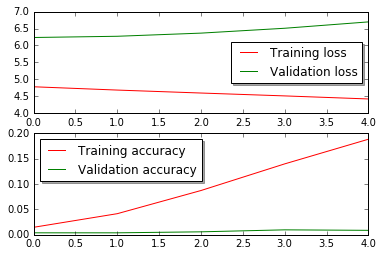

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='r', label="Training loss")
ax[0].plot(history.history['val_loss'], color='g', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='r', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='g',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

In [16]:
results = model.predict(x_test,verbose=1)

10357/10357 [==============================] - 4817s 465ms/step


In [18]:
prediction = pd.DataFrame(results)

# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
prediction.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
prediction.insert(0, 'id', sample_submission['id'])

submission = prediction
submission.to_csv('submission.csv', index=False)